In [2]:
# Copyright 2019-2020 Steven Mattis and Troy Butler

import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
import ipywidgets as wd
from scipy.stats import gaussian_kde as GKDE
from math import *
from luq import *

plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'axes.linewidth': 2})

np.random.seed(123456)

The model is the Sel'kov model for glycolysis, a process by which living cells breakdown sugar to obtain energy:
$$x' = -(x+b) + a \left(y + \frac{b}{a+b^2} \right) + (x+b)^2 \left(y + \frac{b}{a+b^2}\right)$$
$$y' = b-a\left(y+ \frac{b}{a+b^2}\right) - (x+b)^2 \left(y + \frac{b}{a+b^2}\right), $$
where $x$ and $y$ represent concentrations of ADP and F6P, respectively, and $a,b>0$.
The initial conditions are $x(0) = x_0 \in \mathbb{R}$ and $y(0) = y_0 \in \mathbb{R}$.

The system has Hopf Bifurcations at 
$$b = b_1(a) = \sqrt{(1-\sqrt{1-8a}-2a)/2}$$
and
$$b = b_2(a) = \sqrt{(1+\sqrt{1-8a}-2a)/2}.$$
If $b<b_1$, the origin is a stable focus. If $b_1 < b < b_2$, there is a stable periodic orbit.
If $b > b_2$ the origin is a stable focus.

The system is solved numerically using the RK45 method.

A ***true*** distribution of $a, b,  x_0$, and $y_0$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [4]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(3E3)

param_range = np.array([[0.01, 0.124], # a
                       [0.05, 1.5]])  #b
ic_range = np.array([[1.0, 1.0],  # y_0
                     [1.0, 1.0]])  # x_0

params = np.random.uniform(size=(num_samples, 2))
params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params

ics = np.random.uniform(size=(num_samples, 2))
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics

# labels
param_labels = [r'$a$', r'$b$']
ic_labels = [r'$x_0$', r'$y_0$']

# Construct the predicted time series data
time_start = 2.0 #0.5
time_end = 6.5 #40.0
num_time_preds = int((time_end-time_start)*100)  # number of predictions (uniformly space) between [time_start,time_end]
times = np.linspace(time_start, time_end, num_time_preds)

# Solve systems
phys = ds.Selkov()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)

In [5]:
# Simulate an observed Beta distribution of time series data

num_obs = int(5E2)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs

ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

# Solve system
observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = True
noise_stdev = 0.0125

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs, times.shape[0])

In [6]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0
time_end_idx = len(times) - 1#150 #120

# Clean data
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                 num_clean_obs=20, tol=5.0e-2, min_knots=3, max_knots=8)

0 4 0.16432568527150745
0 5 0.07318709105164561
0 6 0.06482547995677138
0 6 knots being used with error of 0.06482547995677138
1 4 0.15700192924398781
1 5 0.06902687945633011
1 6 0.09839360368706962
1 7 0.03561626003914042
1 8 0.024370657076176725
1 8 knots being used with error of 0.024370657076176725
2 4 0.03190620119779684
2 5 0.017518985140891247
2 5 knots being used with error of 0.017518985140891247
3 4 0.1561618319392559
3 5 0.06654280558514046
3 6 0.041067915550389765
3 7 0.03494492027713387
3 7 knots being used with error of 0.03494492027713387
4 4 0.023043095047272366
4 5 0.013061892069683377
4 5 knots being used with error of 0.013061892069683377
5 4 0.027533848196060348
5 5 0.015516361507237631
5 5 knots being used with error of 0.015516361507237631
6 4 0.1549474183820504
6 5 0.06662270309948884
6 6 0.041591858697186436
6 7 0.034738073727287384
6 7 knots being used with error of 0.034738073727287384
7 4 0.037985284203645296
7 5 0.02046298427435577
7 5 knots being used with 

65 7 0.02452649107431287
65 8 0.017174218914490242
65 8 knots being used with error of 0.017174218914490242
66 4 0.08224661952286537
66 5 0.046056444494968526
66 6 0.029132996460925712
66 7 0.020348659249803072
66 7 knots being used with error of 0.020348659249803072
67 4 0.039950103419040414
67 5 0.022839765396586102
67 5 knots being used with error of 0.022839765396586102
68 4 0.05770243092487034
68 5 0.03215238937561288
68 6 0.020539197575530688
68 6 knots being used with error of 0.020539197575530688
69 4 0.037731482756012014
69 5 0.021302792723915196
69 5 knots being used with error of 0.021302792723915196
70 4 0.05766748394751982
70 5 0.03219974521275789
70 6 0.02035784544172719
70 6 knots being used with error of 0.02035784544172719
71 4 0.031391898747221265
71 5 0.01786002107498899
71 5 knots being used with error of 0.01786002107498899
72 4 0.08204038986182866
72 5 0.0458138138816754
72 6 0.029331806197610357
72 7 0.020293199537299546
72 7 knots being used with error of 0.0202

129 4 0.03272733886103271
129 5 0.017946810692604356
129 5 knots being used with error of 0.017946810692604356
130 4 0.1692700460206159
130 5 0.07457811871589787
130 6 0.06658893869014698
130 6 knots being used with error of 0.06658893869014698
131 4 0.1584581930092729
131 5 0.06881620930468214
131 6 0.043621336751431684
131 7 0.0357000893159094
131 7 knots being used with error of 0.0357000893159094
132 4 0.042460648783939244
132 5 0.024263432190708128
132 5 knots being used with error of 0.024263432190708128
133 4 0.04499209483447206
133 5 0.025302424806177188
133 5 knots being used with error of 0.025302424806177188
134 4 0.04726623239083162
134 5 0.026205136677674695
134 6 0.016746928551419318
134 6 knots being used with error of 0.016746928551419318
135 4 0.05539598547116607
135 5 0.03084971132047755
135 6 0.01950257386577961
135 6 knots being used with error of 0.01950257386577961
136 4 0.03202187632354692
136 5 0.01827113574136176
136 5 knots being used with error of 0.018271135

192 6 0.019026523012156536
192 6 knots being used with error of 0.019026523012156536
193 4 0.03202242547279774
193 5 0.017888182232441117
193 5 knots being used with error of 0.017888182232441117
194 4 0.03295591958512059
194 5 0.01861349058924509
194 5 knots being used with error of 0.01861349058924509
195 4 0.05443240231348144
195 5 0.030966032923508947
195 6 0.019929966833514463
195 6 knots being used with error of 0.019929966833514463
196 4 0.03030941073185534
196 5 0.017531334061407965
196 5 knots being used with error of 0.017531334061407965
197 4 0.0234435283607813
197 5 0.01326532294285989
197 5 knots being used with error of 0.01326532294285989
198 4 0.15891550535199772
198 5 0.06947133055471841
198 6 0.06262542466422456
198 6 knots being used with error of 0.06262542466422456
199 4 0.08211274117256323
199 5 0.04356376704894339
199 6 0.027447034725367088
199 6 knots being used with error of 0.027447034725367088
200 4 0.030180098329040284
200 5 0.017520398063484332
200 5 knots 

255 6 0.017579680172752354
255 6 knots being used with error of 0.017579680172752354
256 4 0.16073831193713897
256 5 0.0715482326905574
256 6 0.06334018202673469
256 6 knots being used with error of 0.06334018202673469
257 4 0.07690764151526094
257 5 0.043383681348257895
257 6 0.02781854649321721
257 6 knots being used with error of 0.02781854649321721
258 4 0.07822634523076552
258 5 0.04357437827335697
258 6 0.02900591252184427
258 6 knots being used with error of 0.02900591252184427
259 4 0.09067680345704027
259 5 0.050945489962916396
259 6 0.03244679669776701
259 7 0.022084007552938045
259 7 knots being used with error of 0.022084007552938045
260 4 0.0543416425928205
260 5 0.030352790995162814
260 6 0.0192983496745864
260 6 knots being used with error of 0.0192983496745864
261 4 0.056434734382162746
261 5 0.03133355675552711
261 6 0.019819715139396888
261 6 knots being used with error of 0.019819715139396888
262 4 0.051552856586010366
262 5 0.028807076484489755
262 6 0.0182655111972

319 4 0.05730553021315146
319 5 0.03199098459847054
319 6 0.02027368786908989
319 6 knots being used with error of 0.02027368786908989
320 4 0.16282550634412424
320 5 0.07144203755536856
320 6 0.06388903890523251
320 6 knots being used with error of 0.06388903890523251
321 4 0.09175094502692312
321 5 0.06701245391917254
321 6 0.03820900362896128
321 7 0.025727738885730555
321 7 knots being used with error of 0.025727738885730555
322 4 0.022776758153639467
322 5 0.01272986654798322
322 5 knots being used with error of 0.01272986654798322
323 4 0.0866818207529268
323 5 0.04743832395640421
323 6 0.029609082176873698
323 7 0.02043319989818776
323 7 knots being used with error of 0.02043319989818776
324 4 0.043339186607600104
324 5 0.024391506118407864
324 5 knots being used with error of 0.024391506118407864
325 4 0.10270858541631127
325 5 0.06613715327810486
325 6 0.038649382939177135
325 7 0.02668020637623273
325 7 knots being used with error of 0.02668020637623273
326 4 0.03408275856881

384 5 0.027751965597204293
384 6 0.017668438856371618
384 6 knots being used with error of 0.017668438856371618
385 4 0.1591580682933936
385 5 0.06631298770925337
385 6 0.0397617767606086
385 7 0.03495626629481136
385 7 knots being used with error of 0.03495626629481136
386 4 0.0874443128361683
386 5 0.04718313619487339
386 6 0.029443610356472825
386 7 0.02012885358364545
386 7 knots being used with error of 0.02012885358364545
387 4 0.036443382021789435
387 5 0.02037003396564485
387 5 knots being used with error of 0.02037003396564485
388 4 0.03468310692323303
388 5 0.020136791003768823
388 5 knots being used with error of 0.020136791003768823
389 4 0.05527661200214444
389 5 0.030652594786892765
389 6 0.01955309431395784
389 6 knots being used with error of 0.01955309431395784
390 4 0.15871849176570552
390 5 0.06879791423008606
390 6 0.04347725429913649
390 7 0.03574831418603131
390 7 knots being used with error of 0.03574831418603131
391 4 0.036502917945956864
391 5 0.020094613800519

447 7 0.02686146681826807
447 7 knots being used with error of 0.02686146681826807
448 4 0.05686026340964616
448 5 0.031710479237493726
448 6 0.02019583509882337
448 6 knots being used with error of 0.02019583509882337
449 4 0.033652579013236976
449 5 0.018633742829853726
449 5 knots being used with error of 0.018633742829853726
450 4 0.05766273138883159
450 5 0.0322694661522232
450 6 0.020446055929998944
450 6 knots being used with error of 0.020446055929998944
451 4 0.04627745656197819
451 5 0.025533389868415
451 5 knots being used with error of 0.025533389868415
452 4 0.02416644935909011
452 5 0.013630802690140558
452 5 knots being used with error of 0.013630802690140558
453 4 0.03945961691650604
453 5 0.022717481239338165
453 5 knots being used with error of 0.022717481239338165
454 4 0.15811655622167056
454 5 0.06750420951677333
454 6 0.041256183696577964
454 7 0.03521379577956082
454 7 knots being used with error of 0.03521379577956082
455 4 0.15888599722245345
455 5 0.0705287180

511 5 0.07460199089081289
511 6 0.0673013512811014
511 6 knots being used with error of 0.0673013512811014
512 4 0.08091916025933252
512 5 0.06950605571537063
512 5 knots being used with error of 0.06950605571537063
513 4 0.08178085832684859
513 5 0.04385090666267211
513 6 0.028112067574087705
513 6 knots being used with error of 0.028112067574087705
514 4 0.03684652534450665
514 5 0.02031749770582928
514 5 knots being used with error of 0.02031749770582928
515 4 0.05054197253685683
515 5 0.028384609467950784
515 6 0.01802903082061847
515 6 knots being used with error of 0.01802903082061847
516 4 0.04896603521081945
516 5 0.02785978725451159
516 6 0.017971692693753455
516 6 knots being used with error of 0.017971692693753455
517 4 0.07957131829987507
517 5 0.04334330772043763
517 6 0.028187331375750847
517 6 knots being used with error of 0.028187331375750847
518 4 0.043830632522552024
518 5 0.024307189827535988
518 5 knots being used with error of 0.024307189827535988
519 4 0.15709822

576 4 0.04104069917547517
576 5 0.021830312834336247
576 5 knots being used with error of 0.021830312834336247
577 4 0.04784229070958316
577 5 0.026940377943856748
577 6 0.017135620350300675
577 6 knots being used with error of 0.017135620350300675
578 4 0.051695991853459605
578 5 0.028927602804114196
578 6 0.018401207669950594
578 6 knots being used with error of 0.018401207669950594
579 4 0.05358366979342489
579 5 0.029754691646200954
579 6 0.01904744749925942
579 6 knots being used with error of 0.01904744749925942
580 4 0.05494175798113957
580 5 0.030643955365929905
580 6 0.01953416917013473
580 6 knots being used with error of 0.01953416917013473
581 4 0.03633966583607313
581 5 0.021131749512437407
581 5 knots being used with error of 0.021131749512437407
582 4 0.046854669246524684
582 5 0.0262245817036054
582 5 knots being used with error of 0.0262245817036054
583 4 0.07682168182952759
583 5 0.04688663184602752
583 6 0.03849487096834998
583 6 knots being used with error of 0.0384

641 5 0.06793374399813353
641 6 0.043024362457841366
641 7 0.03535006353064248
641 7 knots being used with error of 0.03535006353064248
642 4 0.022093332743629696
642 5 0.012394396322573744
642 5 knots being used with error of 0.012394396322573744
643 4 0.05749717921451896
643 5 0.032076186859223185
643 6 0.020393976009157943
643 6 knots being used with error of 0.020393976009157943
644 4 0.05702677169791398
644 5 0.03168994881288127
644 6 0.02023705858955402
644 6 knots being used with error of 0.02023705858955402
645 4 0.047069802952818915
645 5 0.026287325266486163
645 6 0.0167090699628804
645 6 knots being used with error of 0.0167090699628804
646 4 0.05210585976950896
646 5 0.028868722541119874
646 6 0.01844110485745321
646 6 knots being used with error of 0.01844110485745321
647 4 0.056526197358443754
647 5 0.03145699770905303
647 6 0.019908909988623904
647 6 knots being used with error of 0.019908909988623904
648 4 0.039648833330266656
648 5 0.021550931806857163
648 5 knots bein

705 5 0.0310030818389438
705 6 0.019715510994893094
705 6 knots being used with error of 0.019715510994893094
706 4 0.045886253357863026
706 5 0.02519470834952444
706 5 knots being used with error of 0.02519470834952444
707 4 0.057301159513157354
707 5 0.032007232802003405
707 6 0.02025590483260692
707 6 knots being used with error of 0.02025590483260692
708 4 0.15609199139288513
708 5 0.06831477813770442
708 6 0.04356630079111001
708 7 0.03539758234013123
708 7 knots being used with error of 0.03539758234013123
709 4 0.0875824982576697
709 5 0.04733919060854218
709 6 0.029532450892166197
709 7 0.020058896390855084
709 7 knots being used with error of 0.020058896390855084
710 4 0.08660767584033768
710 5 0.06750212091141895
710 5 knots being used with error of 0.06750212091141895
711 4 0.036563499715774335
711 5 0.02129128142994144
711 5 knots being used with error of 0.02129128142994144
712 4 0.04893567199442134
712 5 0.027518869709406955
712 6 0.017568106948412925
712 6 knots being us

769 5 0.07431742170088121
769 6 0.06568683449443623
769 6 knots being used with error of 0.06568683449443623
770 4 0.15952933358294108
770 5 0.07076109522388946
770 6 0.06283794174303284
770 6 knots being used with error of 0.06283794174303284
771 4 0.03876584630125166
771 5 0.02103319941448203
771 5 knots being used with error of 0.02103319941448203
772 4 0.0526212536946195
772 5 0.029892383533163557
772 6 0.019273088582137728
772 6 knots being used with error of 0.019273088582137728
773 4 0.08231402296637665
773 5 0.06982415047351839
773 5 knots being used with error of 0.06982415047351839
774 4 0.05002111446135563
774 5 0.02778259430363303
774 6 0.01797238670928692
774 6 knots being used with error of 0.01797238670928692
775 4 0.15869649766993058
775 5 0.06628207187015439
775 6 0.039990180427511575
775 7 0.03496598260874861
775 7 knots being used with error of 0.03496598260874861
776 4 0.10528930201014766
776 5 0.06597644185512586
776 6 0.038968936605963955
776 7 0.02709080832187663

834 4 0.022504989558746337
834 5 0.012637653194456899
834 5 knots being used with error of 0.012637653194456899
835 4 0.0479717222083521
835 5 0.027032825118731924
835 6 0.017185821596044357
835 6 knots being used with error of 0.017185821596044357
836 4 0.038819693611038736
836 5 0.021937986496867085
836 5 knots being used with error of 0.021937986496867085
837 4 0.022616681969326504
837 5 0.012652920386980102
837 5 knots being used with error of 0.012652920386980102
838 4 0.051497764811632304
838 5 0.02880816656886279
838 6 0.018369387375796617
838 6 knots being used with error of 0.018369387375796617
839 4 0.02561979310766125
839 5 0.014372571519544838
839 5 knots being used with error of 0.014372571519544838
840 4 0.026911204022817756
840 5 0.015288323883668003
840 5 knots being used with error of 0.015288323883668003
841 4 0.03669235420138334
841 5 0.021472752921042955
841 5 knots being used with error of 0.021472752921042955
842 4 0.15982625112133597
842 5 0.07069230203249584
842

897 5 0.014242977997051664
897 5 knots being used with error of 0.014242977997051664
898 4 0.1565878727618621
898 5 0.0688671732934083
898 6 0.14966803107609072
898 7 0.03561097146821543
898 8 0.024314809152579546
898 8 knots being used with error of 0.024314809152579546
899 4 0.08275533920190868
899 5 0.04388975594631755
899 6 0.027385957530865
899 7 0.019292292750644018
899 7 knots being used with error of 0.019292292750644018
900 4 0.10379082131323224
900 5 0.06595933303546211
900 6 0.038836128942444835
900 7 0.026958573622790968
900 7 knots being used with error of 0.026958573622790968
901 4 0.1677974887913761
901 5 0.07379034998889498
901 6 0.06608772161029755
901 6 knots being used with error of 0.06608772161029755
902 4 0.048378029821045845
902 5 0.027552980798599976
902 6 0.017670931735831535
902 6 knots being used with error of 0.017670931735831535
903 4 0.03446558244834114
903 5 0.019534101137611094
903 5 knots being used with error of 0.019534101137611094
904 4 0.15517912857

960 6 0.03125320484957501
960 7 0.021811326238838278
960 7 knots being used with error of 0.021811326238838278
961 4 0.1651631440898581
961 5 0.073917363800498
961 6 0.06524357155116813
961 6 knots being used with error of 0.06524357155116813
962 4 0.038683562270913394
962 5 0.021465138975068118
962 5 knots being used with error of 0.021465138975068118
963 4 0.035824490431930915
963 5 0.02014326787940146
963 5 knots being used with error of 0.02014326787940146
964 4 0.05742487587661282
964 5 0.03205711753562478
964 6 0.020399987508098637
964 6 knots being used with error of 0.020399987508098637
965 4 0.08756279200345625
965 5 0.0676028163666746
965 6 0.03807208855266793
965 7 0.02522946147346723
965 7 knots being used with error of 0.02522946147346723
966 4 0.0480948586093284
966 5 0.026740858139647168
966 6 0.017071501769158264
966 6 knots being used with error of 0.017071501769158264
967 4 0.08439429160915705
967 5 0.04672934437174266
967 6 0.029615546962120605
967 7 0.02045610613404

1021 5 0.012517307777417988
1021 5 knots being used with error of 0.012517307777417988
1022 4 0.08452026141887803
1022 5 0.0450885211779837
1022 6 0.028510591016156422
1022 7 0.019896751348519266
1022 7 knots being used with error of 0.019896751348519266
1023 4 0.08591139128571439
1023 5 0.06743988507199826
1023 5 knots being used with error of 0.06743988507199826
1024 4 0.028372282106951963
1024 5 0.016432165548380586
1024 5 knots being used with error of 0.016432165548380586
1025 4 0.08818645579799853
1025 5 0.04786344734214712
1025 6 0.029801180084923513
1025 7 0.020552346721930084
1025 7 knots being used with error of 0.020552346721930084
1026 4 0.046773309744801324
1026 5 0.026247979395011587
1026 5 knots being used with error of 0.026247979395011587
1027 4 0.0324365792934599
1027 5 0.01874563909954319
1027 5 knots being used with error of 0.01874563909954319
1028 4 0.048637922300249506
1028 5 0.02699782442234893
1028 6 0.017221199495782054
1028 6 knots being used with error of 0.

1083 5 0.03125841020341887
1083 6 0.019987665595964235
1083 6 knots being used with error of 0.019987665595964235
1084 4 0.051171757245033415
1084 5 0.02859036086566545
1084 6 0.01818620398169343
1084 6 knots being used with error of 0.01818620398169343
1085 4 0.15755050579042865
1085 5 0.06645774376822083
1085 6 0.040476955850136304
1085 7 0.034998702739070645
1085 7 knots being used with error of 0.034998702739070645
1086 4 0.039501952449164254
1086 5 0.022318797380015656
1086 5 knots being used with error of 0.022318797380015656
1087 4 0.05313303592239685
1087 5 0.030241182104625793
1087 6 0.01945139686241276
1087 6 knots being used with error of 0.01945139686241276
1088 4 0.1579086499615415
1088 5 0.06607390551032664
1088 6 0.04001246925143194
1088 7 0.03488796157481884
1088 7 knots being used with error of 0.03488796157481884
1089 4 0.1572990321906767
1089 5 0.06751405584808325
1089 6 0.04185773112166083
1089 7 0.03531177801346919
1089 7 knots being used with error of 0.0353117780

1145 7 0.035298810516101876
1145 7 knots being used with error of 0.035298810516101876
1146 4 0.03908192456873034
1146 5 0.022372417632530266
1146 5 knots being used with error of 0.022372417632530266
1147 4 0.06811453100997288
1147 5 0.038601838060746976
1147 6 0.024729606199162042
1147 6 knots being used with error of 0.024729606199162042
1148 4 0.1575471687003414
1148 5 0.06781293580755504
1148 6 0.042098577661963156
1148 7 0.0354432834861759
1148 7 knots being used with error of 0.0354432834861759
1149 4 0.05808329435278484
1149 5 0.032384103536071844
1149 6 0.02052737958043809
1149 6 knots being used with error of 0.02052737958043809
1150 4 0.03178297147797998
1150 5 0.018136964440165798
1150 5 knots being used with error of 0.018136964440165798
1151 4 0.03016050689998483
1151 5 0.016644437874496838
1151 5 knots being used with error of 0.016644437874496838
1152 4 0.16048527610036312
1152 5 0.07076781444569336
1152 6 0.06312522860549012
1152 6 knots being used with error of 0.0631

1207 4 0.1732174988441807
1207 5 0.07494560203979292
1207 6 0.06801993070057427
1207 6 knots being used with error of 0.06801993070057427
1208 4 0.16779611981560325
1208 5 0.07432385219435525
1208 6 0.06621426906032113
1208 6 knots being used with error of 0.06621426906032113
1209 4 0.028638270751031866
1209 5 0.016318269167843992
1209 5 knots being used with error of 0.016318269167843992
1210 4 0.16564886838434248
1210 5 0.07232826475530517
1210 6 0.06499572047705716
1210 6 knots being used with error of 0.06499572047705716
1211 4 0.08778236510050362
1211 5 0.04861685346982635
1211 6 0.030848260250684566
1211 7 0.021570749348103477
1211 7 knots being used with error of 0.021570749348103477
1212 4 0.16628280081890806
1212 5 0.0727429680494123
1212 6 0.06520685896553385
1212 6 knots being used with error of 0.06520685896553385
1213 4 0.04695576928286198
1213 5 0.02605632927078444
1213 6 0.016660838613895623
1213 6 knots being used with error of 0.016660838613895623
1214 4 0.159377225652

1269 7 0.03508276219177382
1269 7 knots being used with error of 0.03508276219177382
1270 4 0.037519237321011756
1270 5 0.021594158842801445
1270 5 knots being used with error of 0.021594158842801445
1271 4 0.05498831833539651
1271 5 0.0307161401001414
1271 6 0.019546246242705352
1271 6 knots being used with error of 0.019546246242705352
1272 4 0.11215059072441738
1272 5 0.0659759831543778
1272 6 0.039530989860922565
1272 7 0.02791142368322936
1272 7 knots being used with error of 0.02791142368322936
1273 4 0.032194855335688506
1273 5 0.017777334684553076
1273 5 knots being used with error of 0.017777334684553076
1274 4 0.054771821026879275
1274 5 0.03113357184567846
1274 6 0.020050940698321976
1274 6 knots being used with error of 0.020050940698321976
1275 4 0.052528342364833294
1275 5 0.029926870141467225
1275 6 0.019212610844808863
1275 6 knots being used with error of 0.019212610844808863
1276 4 0.1127636792832021
1276 5 0.06600062343557153
1276 6 0.039579572857372416
1276 7 0.1086

1329 7 0.03563565774306332
1329 7 knots being used with error of 0.03563565774306332
1330 4 0.022523216080676436
1330 5 0.01265622930388717
1330 5 knots being used with error of 0.01265622930388717
1331 4 0.05775434539917521
1331 5 0.03212455261575729
1331 6 0.020435448234483202
1331 6 knots being used with error of 0.020435448234483202
1332 4 0.1110113895376667
1332 5 0.06585672095661982
1332 6 0.03938342791815677
1332 7 0.027805894233504425
1332 7 knots being used with error of 0.027805894233504425
1333 4 0.021751583437830884
1333 5 0.012213417371749894
1333 5 knots being used with error of 0.012213417371749894
1334 4 0.08765774738966092
1334 5 0.06749607460088815
1334 6 0.037996159240879575
1334 7 0.025172023699355648
1334 7 knots being used with error of 0.025172023699355648
1335 4 0.03223088539713839
1335 5 0.018131714936531224
1335 5 knots being used with error of 0.018131714936531224
1336 4 0.08486229706278603
1336 5 0.06825464467268304
1336 5 knots being used with error of 0.06

1391 5 0.029266986808102725
1391 6 0.018574677819353628
1391 6 knots being used with error of 0.018574677819353628
1392 4 0.021035017207963896
1392 5 0.011816333832025776
1392 5 knots being used with error of 0.011816333832025776
1393 4 0.15519496110197942
1393 5 0.06778102560260565
1393 6 0.043102437946571044
1393 7 0.03521642675063395
1393 7 knots being used with error of 0.03521642675063395
1394 4 0.037817207700573556
1394 5 0.020368609169303747
1394 5 knots being used with error of 0.020368609169303747
1395 4 0.04011367296993081
1395 5 0.022516124147057913
1395 5 knots being used with error of 0.022516124147057913
1396 4 0.09040215637816065
1396 5 0.0667963418200033
1396 6 0.037897285477574934
1396 7 0.025321463477365972
1396 7 knots being used with error of 0.025321463477365972
1397 4 0.027573885938665877
1397 5 0.015527089504701212
1397 5 knots being used with error of 0.015527089504701212
1398 4 0.09219959057715961
1398 5 0.06690013396750667
1398 6 0.03819215039276747
1398 7 0.0

1452 6 0.01965085042636188
1452 6 knots being used with error of 0.01965085042636188
1453 4 0.06952191502462753
1453 5 0.039298615019965386
1453 6 0.02535120075918052
1453 6 knots being used with error of 0.02535120075918052
1454 4 0.03304921066209714
1454 5 0.018770931042595796
1454 5 knots being used with error of 0.018770931042595796
1455 4 0.10876063139982625
1455 5 0.06618117679824216
1455 6 0.03918937770992134
1455 7 0.24173722315016966
1455 8 0.02255419540122424
1456 4 0.03427230996216909
1456 5 0.019641297186745624
1456 5 knots being used with error of 0.019641297186745624
1457 4 0.07785902286078167
1457 5 0.04588057166074792
1457 6 0.032423078350734616
1457 6 knots being used with error of 0.032423078350734616
1458 4 0.1555262428602157
1458 5 0.06665595337992043
1458 6 0.041510080986199356
1458 7 0.03486309306992315
1458 7 knots being used with error of 0.03486309306992315
1459 4 0.1593470755795751
1459 5 0.06901280458522067
1459 6 0.04360459060424836
1459 7 0.0358452895989854

1514 6 0.027666390821743336
1514 6 knots being used with error of 0.027666390821743336
1515 4 0.055964745611900374
1515 5 0.031214195261859503
1515 6 0.019805350516426068
1515 6 knots being used with error of 0.019805350516426068
1516 4 0.02364519537334764
1516 5 0.013419172609633538
1516 5 knots being used with error of 0.013419172609633538
1517 4 0.05121290096056809
1517 5 0.02853026118851572
1517 6 0.018101010131743794
1517 6 knots being used with error of 0.018101010131743794
1518 4 0.041904224968329705
1518 5 0.02337936578847253
1518 5 knots being used with error of 0.02337936578847253
1519 4 0.15489978742222227
1519 5 0.06714577084530221
1519 6 0.04223359841314257
1519 7 0.03475092613683026
1519 7 knots being used with error of 0.03475092613683026
1520 4 0.05324737330037728
1520 5 0.02963063610702005
1520 6 0.018805125724443584
1520 6 knots being used with error of 0.018805125724443584
1521 4 0.1656140039589654
1521 5 0.07329570426517408
1521 6 0.06501575630288339
1521 6 knots be

1576 5 0.07071077674994852
1576 6 0.06285020857134008
1576 6 knots being used with error of 0.06285020857134008
1577 4 0.049891249884316556
1577 5 0.02842888134469125
1577 6 0.018224974039916384
1577 6 knots being used with error of 0.018224974039916384
1578 4 0.09040666947670443
1578 5 0.04984283938840611
1578 6 0.03166977719953118
1578 7 0.021394524106338977
1578 7 knots being used with error of 0.021394524106338977
1579 4 0.16806725883652696
1579 5 0.07370665637219252
1579 6 0.06619635152734187
1579 6 knots being used with error of 0.06619635152734187
1580 4 0.05055653196136528
1580 5 0.028360801861510507
1580 6 0.01816637209952117
1580 6 knots being used with error of 0.01816637209952117
1581 4 0.04713737379078977
1581 5 0.02653838581238178
1581 6 0.016978407240965682
1581 6 knots being used with error of 0.016978407240965682
1582 4 0.0882561103983724
1582 5 0.06775046469641277
1582 6 0.03812536817196332
1582 7 0.02538681923771339
1582 7 knots being used with error of 0.02538681923

1637 6 0.03879549213221281
1637 6 knots being used with error of 0.03879549213221281
1638 4 0.07811944371653386
1638 5 0.05001488003502032
1638 6 0.03764948947071342
1638 6 knots being used with error of 0.03764948947071342
1639 4 0.05224036434938657
1639 5 0.029135112971704794
1639 6 0.018605071826956966
1639 6 knots being used with error of 0.018605071826956966
1640 4 0.15867589121808987
1640 5 0.07012791107676647
1640 6 0.0625958967329869
1640 6 knots being used with error of 0.0625958967329869
1641 4 0.08682211990750173
1641 5 0.0676681051737616
1641 6 0.037990555643738044
1641 7 0.025106741361519972
1641 7 knots being used with error of 0.025106741361519972
1642 4 0.15546558676544184
1642 5 0.06647347489958082
1642 6 0.04118507915211257
1642 7 0.034826919885479764
1642 7 knots being used with error of 0.034826919885479764
1643 4 0.04125223606002214
1643 5 0.022155251278899998
1643 5 knots being used with error of 0.022155251278899998
1644 4 0.05215362435384886
1644 5 0.02912349600

1699 4 0.058544874900594596
1699 5 0.03260805937364729
1699 6 0.020847408215620655
1699 6 knots being used with error of 0.020847408215620655
1700 4 0.05805445647859273
1700 5 0.0323420440150837
1700 6 0.020517895319223926
1700 6 knots being used with error of 0.020517895319223926
1701 4 0.03657237049334788
1701 5 0.021071689285060646
1701 5 knots being used with error of 0.021071689285060646
1702 4 0.16833708261461994
1702 5 0.07439062630751117
1702 6 0.06647907875873625
1702 6 knots being used with error of 0.06647907875873625
1703 4 0.040341488141081835
1703 5 0.023108386074372364
1703 5 knots being used with error of 0.023108386074372364
1704 4 0.023526476269315807
1704 5 0.01325665071708191
1704 5 knots being used with error of 0.01325665071708191
1705 4 0.16257756275073112
1705 5 0.07108640856383087
1705 6 0.06387666857463041
1705 6 knots being used with error of 0.06387666857463041
1706 4 0.16798178446204998
1706 5 0.07371717926378717
1706 6 0.06616783444868797
1706 6 knots bein

1761 4 0.05648549739779987
1761 5 0.03159819388525181
1761 6 0.019975655739819412
1761 6 knots being used with error of 0.019975655739819412
1762 4 0.04767461729747985
1762 5 0.026053755593280478
1762 5 knots being used with error of 0.026053755593280478
1763 4 0.055238548484331164
1763 5 0.03080712882625987
1763 6 0.019672086221698748
1763 6 knots being used with error of 0.019672086221698748
1764 4 0.04840945532390925
1764 5 0.026960994845526297
1764 6 0.01732336008809906
1764 6 knots being used with error of 0.01732336008809906
1765 4 0.029293375942278814
1765 5 0.01704426942886759
1765 5 knots being used with error of 0.01704426942886759
1766 4 0.043556394277914835
1766 5 0.024802044391067618
1766 5 knots being used with error of 0.024802044391067618
1767 4 0.03448550603199519
1767 5 0.020012232746385236
1767 5 knots being used with error of 0.020012232746385236
1768 4 0.0842168934612864
1768 5 0.045417972919187116
1768 6 0.02811337941155534
1768 7 0.01923660671228723
1768 7 knots 

1822 6 0.01946868423072867
1822 6 knots being used with error of 0.01946868423072867
1823 4 0.027199279473226066
1823 5 0.015570404191061978
1823 5 knots being used with error of 0.015570404191061978
1824 4 0.026873523842587867
1824 5 0.015455074097740272
1824 5 knots being used with error of 0.015455074097740272
1825 4 0.09419406726429001
1825 5 0.06646071435333066
1825 6 0.03796229700897707
1825 7 0.025677078955162403
1825 7 knots being used with error of 0.025677078955162403
1826 4 0.07948700823482524
1826 5 0.04328417317949784
1826 6 0.02815134061234705
1826 6 knots being used with error of 0.02815134061234705
1827 4 0.027012762853290326
1827 5 0.015491796176902408
1827 5 knots being used with error of 0.015491796176902408
1828 4 0.08912356339900793
1828 5 0.05002974533122325
1828 6 0.03215340632759398
1828 7 0.021961354226607725
1828 7 knots being used with error of 0.021961354226607725
1829 4 0.15728774438421206
1829 5 0.0679927050134565
1829 6 0.04276389508244625
1829 7 0.035428

1883 4 0.042650364379503154
1883 5 0.023917890553690667
1883 5 knots being used with error of 0.023917890553690667
1884 4 0.02581724695147472
1884 5 0.014539266595786462
1884 5 knots being used with error of 0.014539266595786462
1885 4 0.024705457049250857
1885 5 0.013947924947156992
1885 5 knots being used with error of 0.013947924947156992
1886 4 0.07842262876234324
1886 5 0.049297388909751966
1886 6 0.03866019931766777
1886 6 knots being used with error of 0.03866019931766777
1887 4 0.07769001704850875
1887 5 0.04630315180920684
1887 6 0.039855349349573875
1887 6 knots being used with error of 0.039855349349573875
1888 4 0.16676073085211218
1888 5 0.07347550181125832
1888 6 0.06555698608914211
1888 6 knots being used with error of 0.06555698608914211
1889 4 0.08182858967999004
1889 5 0.04343987626849613
1889 6 0.027255238538330836
1889 6 knots being used with error of 0.027255238538330836
1890 4 0.04812732121860085
1890 5 0.027357883887166028
1890 6 0.01761743198500961
1890 6 knots 

1947 5 0.019558346106209233
1947 5 knots being used with error of 0.019558346106209233
1948 4 0.08078569000649954
1948 5 0.043365718327593006
1948 6 0.027737444031034404
1948 6 knots being used with error of 0.027737444031034404
1949 4 0.10354534150256078
1949 5 0.06602150039702241
1949 6 0.038828091830617334
1949 7 0.026884005173169297
1949 7 knots being used with error of 0.026884005173169297
1950 4 0.057926757138618355
1950 5 0.03223915691605983
1950 6 0.020439654351182564
1950 6 knots being used with error of 0.020439654351182564
1951 4 0.06810175481597532
1951 5 0.03857567628014132
1951 6 0.024655942312282957
1951 6 knots being used with error of 0.024655942312282957
1952 4 0.050300874953698116
1952 5 0.028198358761853247
1952 6 0.017964536133534666
1952 6 knots being used with error of 0.017964536133534666
1953 4 0.04209688408779183
1953 5 0.0236201395343941
1953 5 knots being used with error of 0.0236201395343941
1954 4 0.16118038368145587
1954 5 0.07113126069219107
1954 6 0.063

2007 6 0.06473197919303018
2007 6 knots being used with error of 0.06473197919303018
2008 4 0.034779099458781784
2008 5 0.019059559117222513
2008 5 knots being used with error of 0.019059559117222513
2009 4 0.08153514063864445
2009 5 0.043268871840001936
2009 6 0.027055352221837522
2009 6 knots being used with error of 0.027055352221837522
2010 4 0.05789968078309408
2010 5 0.03219998076863703
2010 6 0.02050113198010554
2010 6 knots being used with error of 0.02050113198010554
2011 4 0.0893866669101517
2011 5 0.04897051988952206
2011 6 0.030888930428707197
2011 7 0.021412454911999782
2011 7 knots being used with error of 0.021412454911999782
2012 4 0.03439812549319981
2012 5 0.019672376881114614
2012 5 knots being used with error of 0.019672376881114614
2013 4 0.1692688089983691
2013 5 0.07450810557655765
2013 6 0.06671813243987258
2013 6 knots being used with error of 0.06671813243987258
2014 4 0.038264609675567114
2014 5 0.021778178476313415
2014 5 knots being used with error of 0.021

2069 5 0.03044290324650695
2069 6 0.01945733650975633
2069 6 knots being used with error of 0.01945733650975633
2070 4 0.08263456147768099
2070 5 0.04488070669045062
2070 6 0.029090578463821983
2070 6 knots being used with error of 0.029090578463821983
2071 4 0.0758581951930609
2071 5 0.0428284771001278
2071 6 0.02743656745300967
2071 6 knots being used with error of 0.02743656745300967
2072 4 0.16077948747911322
2072 5 0.0709242126387093
2072 6 0.06322938245616216
2072 6 knots being used with error of 0.06322938245616216
2073 4 0.08414988143691177
2073 5 0.04702213632049333
2073 6 0.02984713744645144
2073 7 0.02072591097834738
2073 7 knots being used with error of 0.02072591097834738
2074 4 0.03988865093431333
2074 5 0.02159969168485209
2074 5 knots being used with error of 0.02159969168485209
2075 4 0.10920649461059909
2075 5 0.06577580785306618
2075 6 0.039225611812347454
2075 7 0.027599395623037058
2075 7 knots being used with error of 0.027599395623037058
2076 4 0.0562292330208232

2130 5 0.07275089314331913
2130 6 0.0650901253221892
2130 6 knots being used with error of 0.0650901253221892
2131 4 0.164637331094421
2131 5 0.07304098331070694
2131 6 0.06489408583489971
2131 6 knots being used with error of 0.06489408583489971
2132 4 0.16580267510729646
2132 5 0.07247175938623927
2132 6 0.0652212126954183
2132 6 knots being used with error of 0.0652212126954183
2133 4 0.04127027725579094
2133 5 0.022975060852716694
2133 5 knots being used with error of 0.022975060852716694
2134 4 0.030403008763900806
2134 5 0.016879834056730034
2134 5 knots being used with error of 0.016879834056730034
2135 4 0.08958903023852012
2135 5 0.04897805528832398
2135 6 0.031023683057772398
2135 7 0.021014051108310103
2135 7 knots being used with error of 0.021014051108310103
2136 4 0.0450482480242411
2136 5 0.025158530135653463
2136 5 knots being used with error of 0.025158530135653463
2137 4 0.08145307412220804
2137 5 0.06826758689414249
2137 5 knots being used with error of 0.06826758689

2194 4 0.16064291387879492
2194 5 0.07011028923202191
2194 6 0.0631076569189078
2194 6 knots being used with error of 0.0631076569189078
2195 4 0.055100523688194306
2195 5 0.030611329654045633
2195 6 0.019575488011475514
2195 6 knots being used with error of 0.019575488011475514
2196 4 0.16057902236264135
2196 5 0.07031829807569144
2196 6 0.06324936201013766
2196 6 knots being used with error of 0.06324936201013766
2197 4 0.03125737458480087
2197 5 0.017500062534243965
2197 5 knots being used with error of 0.017500062534243965
2198 4 0.0602400355171762
2198 5 0.03432555423521324
2198 6 0.02196178837173205
2198 6 knots being used with error of 0.02196178837173205
2199 4 0.022149568930107992
2199 5 0.012435371585855387
2199 5 knots being used with error of 0.012435371585855387
2200 4 0.04702927616290715
2200 5 0.026717086943300872
2200 6 0.01726080944189605
2200 6 knots being used with error of 0.01726080944189605
2201 4 0.035583574820496025
2201 5 0.019222627671373352
2201 5 knots being

2255 4 0.16001094105600505
2255 5 0.06987812794783684
2255 6 0.06291622688294425
2255 6 knots being used with error of 0.06291622688294425
2256 4 0.15617921482468408
2256 5 0.06858707598889348
2256 6 0.04396681545276093
2256 7 0.03547958190296492
2256 7 knots being used with error of 0.03547958190296492
2257 4 0.04853574664692012
2257 5 0.02732832619715093
2257 6 0.017326989300265532
2257 6 knots being used with error of 0.017326989300265532
2258 4 0.057335780557537505
2258 5 0.031997526282288226
2258 6 0.020326356180334692
2258 6 knots being used with error of 0.020326356180334692
2259 4 0.1670915564765904
2259 5 0.07306459279305519
2259 6 0.06567418357076259
2259 6 knots being used with error of 0.06567418357076259
2260 4 0.04138830456541903
2260 5 0.022454357972348543
2260 5 knots being used with error of 0.022454357972348543
2261 4 0.057499310343568796
2261 5 0.032115501396431094
2261 6 0.020299266845252687
2261 6 knots being used with error of 0.020299266845252687
2262 4 0.1597269

2316 5 0.0185379994418778
2316 5 knots being used with error of 0.0185379994418778
2317 4 0.15556489356296982
2317 5 0.06677527780832053
2317 6 0.04169127784373906
2317 7 0.03487671383718735
2317 7 knots being used with error of 0.03487671383718735
2318 4 0.08482383706111127
2318 5 0.047298264568976144
2318 6 0.029953085385870114
2318 7 0.020776946442341612
2318 7 knots being used with error of 0.020776946442341612
2319 4 0.1610280557045228
2319 5 0.07114322673021994
2319 6 0.06327939203469514
2319 6 knots being used with error of 0.06327939203469514
2320 4 0.04334132257016818
2320 5 0.024442491670896797
2320 5 knots being used with error of 0.024442491670896797
2321 4 0.03917868523923808
2321 5 0.022413785967575182
2321 5 knots being used with error of 0.022413785967575182
2322 4 0.09536520460994698
2322 5 0.06639749380336232
2322 6 0.03826693370161777
2322 7 0.025929585448878915
2322 7 knots being used with error of 0.025929585448878915
2323 4 0.03834111667614193
2323 5 0.02044720179

2376 6 0.02049544483812013
2376 6 knots being used with error of 0.02049544483812013
2377 4 0.0577448080479273
2377 5 0.03204692336830773
2377 6 0.020528209050401265
2377 6 knots being used with error of 0.020528209050401265
2378 4 0.08430721292549556
2378 5 0.06833019596868943
2378 5 knots being used with error of 0.06833019596868943
2379 4 0.10383733180947056
2379 5 0.06604041033152627
2379 6 0.03883110008093693
2379 7 0.02689607365040821
2379 7 knots being used with error of 0.02689607365040821
2380 4 0.062410929986418784
2380 5 0.03530914641831069
2380 6 0.022835215149271174
2380 6 knots being used with error of 0.022835215149271174
2381 4 0.11140879864259129
2381 5 0.06587884489805816
2381 6 0.039448526792360016
2381 7 0.02784482295301338
2381 7 knots being used with error of 0.02784482295301338
2382 4 0.040236247155950644
2382 5 0.02280081300993019
2382 5 knots being used with error of 0.02280081300993019
2383 4 0.02887439881746173
2383 5 0.01585887866300767
2383 5 knots being us

2438 4 0.05334321835409474
2438 5 0.029845035470531092
2438 6 0.01904872035806927
2438 6 knots being used with error of 0.01904872035806927
2439 4 0.03216648065185731
2439 5 0.017993171256219083
2439 5 knots being used with error of 0.017993171256219083
2440 4 0.033017863317193544
2440 5 0.018846060667502943
2440 5 knots being used with error of 0.018846060667502943
2441 4 0.03557643139066508
2441 5 0.020352420762382587
2441 5 knots being used with error of 0.020352420762382587
2442 4 0.022105475580729107
2442 5 0.012407529662615838
2442 5 knots being used with error of 0.012407529662615838
2443 4 0.1566288443817268
2443 5 0.06806858878743183
2443 6 0.04317781332736611
2443 7 0.035432098939149816
2443 7 knots being used with error of 0.035432098939149816
2444 4 0.16364856435172906
2444 5 0.07327385876063812
2444 6 0.06480147430631338
2444 6 knots being used with error of 0.06480147430631338
2445 4 0.05444408937505425
2445 5 0.030835306534870717
2445 6 0.0199482196652623
2445 6 knots be

2498 6 0.04126560696473396
2498 7 0.034627635842930125
2498 7 knots being used with error of 0.034627635842930125
2499 4 0.02380002083709766
2499 5 0.0134775227693244
2499 5 knots being used with error of 0.0134775227693244
2500 4 0.15862863337120525
2500 5 0.06882552959086793
2500 6 0.04357872300711967
2500 7 0.035765212172837964
2500 7 knots being used with error of 0.035765212172837964
2501 4 0.1674793994229343
2501 5 0.073886014665142
2501 6 0.06597057150998517
2501 6 knots being used with error of 0.06597057150998517
2502 4 0.15744668403831066
2502 5 0.06768780731224609
2502 6 0.04214138262743955
2502 7 0.03544500180530071
2502 7 knots being used with error of 0.03544500180530071
2503 4 0.05472581259992192
2503 5 0.03055880687147964
2503 6 0.019406135296086764
2503 6 knots being used with error of 0.019406135296086764
2504 4 0.0772068996798242
2504 5 0.04733110533320394
2504 6 0.0387007914800513
2504 6 knots being used with error of 0.0387007914800513
2505 4 0.15619011225856788
25

2558 5 0.051617612889021385
2558 6 0.03845508476991654
2558 6 knots being used with error of 0.03845508476991654
2559 4 0.16650823521954533
2559 5 0.07359212090500836
2559 6 0.06548294316490333
2559 6 knots being used with error of 0.06548294316490333
2560 4 0.03730615828703156
2560 5 0.020906119566097867
2560 5 knots being used with error of 0.020906119566097867
2561 4 0.04476562868785179
2561 5 0.02554706373647917
2561 5 knots being used with error of 0.02554706373647917
2562 4 0.1586129821715442
2562 5 0.06618483977296861
2562 6 0.039835569755497936
2562 7 0.03497184477626917
2562 7 knots being used with error of 0.03497184477626917
2563 4 0.037670086729880606
2563 5 0.02184210166914055
2563 5 knots being used with error of 0.02184210166914055
2564 4 0.17152795398321613
2564 5 0.07488492870071643
2564 6 0.06726080327803505
2564 6 knots being used with error of 0.06726080327803505
2565 4 0.06502131857943552
2565 5 0.03678160268104361
2565 6 0.023761814891337267
2565 6 knots being use

2617 4 0.035707838758016995
2617 5 0.0197386834382532
2617 5 knots being used with error of 0.0197386834382532
2618 4 0.1034407165725583
2618 5 0.06614727069796003
2618 6 0.03872987543063722
2618 7 0.026789901489479538
2618 7 knots being used with error of 0.026789901489479538
2619 4 0.02655878516945353
2619 5 0.015057092643171038
2619 5 knots being used with error of 0.015057092643171038
2620 4 0.04379681774972847
2620 5 0.024565587681177656
2620 5 knots being used with error of 0.024565587681177656
2621 4 0.04764211915878552
2621 5 0.027065643939366058
2621 6 0.01737547005066572
2621 6 knots being used with error of 0.01737547005066572
2622 4 0.07727936203120246
2622 5 0.04420073827798902
2622 6 0.030221641292428398
2622 6 knots being used with error of 0.030221641292428398
2623 4 0.16875785351799008
2623 5 0.07465807924439163
2623 6 0.06632569632654492
2623 6 knots being used with error of 0.06632569632654492
2624 4 0.04493755945685292
2624 5 0.024829757453920957
2624 5 knots being 

2679 7 0.02099676829815025
2679 7 knots being used with error of 0.02099676829815025
2680 4 0.08370759021342099
2680 5 0.04680372118800111
2680 6 0.029758643526202756
2680 6 knots being used with error of 0.029758643526202756
2681 4 0.050468347495686086
2681 5 0.02829135614634911
2681 6 0.01798095424122414
2681 6 knots being used with error of 0.01798095424122414
2682 4 0.04081804576770754
2682 5 0.02321743513240593
2682 5 knots being used with error of 0.02321743513240593
2683 4 0.03773792788613416
2683 5 0.020761396535964958
2683 5 knots being used with error of 0.020761396535964958
2684 4 0.04099944639684775
2684 5 0.023307703344472352
2684 5 knots being used with error of 0.023307703344472352
2685 4 0.0800804745522151
2685 5 0.05272921153018809
2685 6 0.03796931195598694
2685 6 knots being used with error of 0.03796931195598694
2686 4 0.042536428164986366
2686 5 0.023841152626515292
2686 5 knots being used with error of 0.023841152626515292
2687 4 0.05562419503180921
2687 5 0.03104

2743 4 0.1629204782855843
2743 5 0.0714704856129566
2743 6 0.06409476317066848
2743 6 knots being used with error of 0.06409476317066848
2744 4 0.030775467370491905
2744 5 0.017555858514192054
2744 5 knots being used with error of 0.017555858514192054
2745 4 0.15698356995188742
2745 5 0.06760829087396471
2745 6 0.04205161060616953
2745 7 0.03530158850937478
2745 7 knots being used with error of 0.03530158850937478
2746 4 0.05242976813271302
2746 5 0.02924156763143591
2746 6 0.01861542207332462
2746 6 knots being used with error of 0.01861542207332462
2747 4 0.1596039924720384
2747 5 0.06948438432874038
2747 6 0.0628566706363224
2747 6 knots being used with error of 0.0628566706363224
2748 4 0.03661538636106831
2748 5 0.019973187199328533
2748 5 knots being used with error of 0.019973187199328533
2749 4 0.05625338581915387
2749 5 0.031094888254467736
2749 6 0.019657781150517348
2749 6 knots being used with error of 0.019657781150517348
2750 4 0.07877495006025549
2750 5 0.048755800001384

2804 5 0.030885000005806764
2804 6 0.019660844232454337
2804 6 knots being used with error of 0.019660844232454337
2805 4 0.03398797793712914
2805 5 0.01911549011452632
2805 5 knots being used with error of 0.01911549011452632
2806 4 0.07823630168402296
2806 5 0.04400711013626009
2806 6 0.028281739435683725
2806 6 knots being used with error of 0.028281739435683725
2807 4 0.15567415641910867
2807 5 0.0660447763608936
2807 6 0.040643149696613375
2807 7 0.03459882380544964
2807 7 knots being used with error of 0.03459882380544964
2808 4 0.041969401662007425
2808 5 0.023481520822457597
2808 5 knots being used with error of 0.023481520822457597
2809 4 0.08455772500457773
2809 5 0.04601447037947566
2809 6 0.028717712039153947
2809 6 knots being used with error of 0.028717712039153947
2810 4 0.039292185573594735
2810 5 0.0226574242131632
2810 5 knots being used with error of 0.0226574242131632
2811 4 0.05773824270229444
2811 5 0.032177371769947026
2811 6 0.020568182312483783
2811 6 knots bei

2867 5 0.017901115863547278
2867 5 knots being used with error of 0.017901115863547278
2868 4 0.052496477622346424
2868 5 0.029140294493792726
2868 6 0.018652340480493003
2868 6 knots being used with error of 0.018652340480493003
2869 4 0.051007550703203126
2869 5 0.028575545560652536
2869 6 0.01814697180036189
2869 6 knots being used with error of 0.01814697180036189
2870 4 0.07636912803204586
2870 5 0.044309033708095115
2870 6 0.030804561518321495
2870 6 knots being used with error of 0.030804561518321495
2871 4 0.025601570687800345
2871 5 0.014492600294193372
2871 5 knots being used with error of 0.014492600294193372
2872 4 0.03377774283030005
2872 5 0.019176956889988463
2872 5 knots being used with error of 0.019176956889988463
2873 4 0.021518802181938565
2873 5 0.012077119151477982
2873 5 knots being used with error of 0.012077119151477982
2874 4 0.04947145056779076
2874 5 0.027508887367645653
2874 6 0.017415923366633092
2874 6 knots being used with error of 0.017415923366633092
2

2931 4 0.17176868510725482
2931 5 0.07464761828413832
2931 6 0.06735041531710036
2931 6 knots being used with error of 0.06735041531710036
2932 4 0.03190494018037881
2932 5 0.017541713947168684
2932 5 knots being used with error of 0.017541713947168684
2933 4 0.046952269444998584
2933 5 0.025710372908616504
2933 5 knots being used with error of 0.025710372908616504
2934 4 0.026658899536189887
2934 5 0.015089434489119603
2934 5 knots being used with error of 0.015089434489119603
2935 4 0.15782960083587488
2935 5 0.06661441221737516
2935 6 0.04063872613853585
2935 7 0.03502814411749746
2935 7 knots being used with error of 0.03502814411749746
2936 4 0.04016099521141853
2936 5 0.022204215303411073
2936 5 knots being used with error of 0.022204215303411073
2937 4 0.03674412022662541
2937 5 0.020387232890852907
2937 5 knots being used with error of 0.020387232890852907
2938 4 0.16366829292963314
2938 5 0.07204457198127096
2938 6 0.06447381125458751
2938 6 knots being used with error of 0.06

2992 5 0.03224095347417862
2992 6 0.020439167775306473
2992 6 knots being used with error of 0.020439167775306473
2993 4 0.019449517065327136
2993 4 knots being used with error of 0.019449517065327136
2994 4 0.056986338066663055
2994 5 0.031748251326823344
2994 6 0.02022224034679879
2994 6 knots being used with error of 0.02022224034679879
2995 4 0.1600280789120484
2995 5 0.07116273894417306
2995 6 0.06296442727983248
2995 6 knots being used with error of 0.06296442727983248
2996 4 0.04970333028565733
2996 5 0.027748495746912738
2996 6 0.01775519541948042
2996 6 knots being used with error of 0.01775519541948042
2997 4 0.04818787244604343
2997 5 0.027496438767662626
2997 6 0.01768022310189283
2997 6 knots being used with error of 0.01768022310189283
2998 4 0.0846927144803386
2998 5 0.06741461334135444
2998 5 knots being used with error of 0.06741461334135444
2999 4 0.16149038690150433
2999 5 0.07179002384705577
2999 6 0.06357598958952249
2999 6 knots being used with error of 0.06357598

59 6 0.03801128825744199
59 6 knots being used with error of 0.03801128825744199
60 4 0.1053333541102954
60 5 0.10203933196224402
60 5 knots being used with error of 0.10203933196224402
61 4 0.05999352838529921
61 5 0.050949808174384596
61 5 knots being used with error of 0.050949808174384596
62 4 0.09981643903388472
62 5 0.080092566633085
62 6 0.07682066547629979
62 6 knots being used with error of 0.07682066547629979
63 4 0.04554045958138806
63 5 0.03394421806853046
63 5 knots being used with error of 0.03394421806853046
64 4 0.068809109890621
64 5 0.05068091655349983
64 6 0.04677874838786332
64 6 knots being used with error of 0.04677874838786332
65 4 0.0524005238887244
65 5 0.04503627079213491
65 5 knots being used with error of 0.04503627079213491
66 4 0.04990749597492538
66 5 0.043120977961238996
66 5 knots being used with error of 0.043120977961238996
67 4 0.10674703429462327
67 5 0.1005644362529211
67 5 knots being used with error of 0.1005644362529211
68 4 0.04721756258530017


126 5 0.20091562847193642
126 6 0.20039387627884023
126 6 knots being used with error of 0.20039387627884023
127 4 0.049144695538359366
127 5 0.042918720276625195
127 5 knots being used with error of 0.042918720276625195
128 4 0.09786463991984805
128 5 0.06712807662521084
128 6 0.057376439894691024
128 7 0.05080948174044506
128 7 knots being used with error of 0.05080948174044506
129 4 0.04601813540689273
129 5 0.03906890481994189
129 5 knots being used with error of 0.03906890481994189
130 4 0.1227242409120207
130 5 0.11190362746291306
130 6 0.09293930767683616
130 7 0.09176050083045077
130 7 knots being used with error of 0.09176050083045077
131 4 0.1420874232483257
131 5 0.12195304241589987
131 6 0.10818164636444706
131 7 0.10539846658751906
131 7 knots being used with error of 0.10539846658751906
132 4 0.06953165250124548
132 5 0.05271372688742361
132 6 0.043852280089814205
132 6 knots being used with error of 0.043852280089814205
133 4 0.042162678793023226
133 5 0.0356481027801763

192 4 0.04062722325889755
192 5 0.031933422624183735
192 5 knots being used with error of 0.031933422624183735
193 4 0.11606982616923639
193 5 0.09489578582389029
193 6 0.08757994059988607
193 6 knots being used with error of 0.08757994059988607
194 4 0.044291695569019095
194 5 0.03766870892694229
194 5 knots being used with error of 0.03766870892694229
195 4 0.05953481869651146
195 5 0.04603798251824051
195 5 knots being used with error of 0.04603798251824051
196 4 0.10467830475408776
196 5 0.08375106558318805
196 6 0.07668665369642777
196 6 knots being used with error of 0.07668665369642777
197 4 0.058237040951109466
197 5 0.04884471932365149
197 5 knots being used with error of 0.04884471932365149
198 4 0.12116438550910115
198 5 0.11656101785413951
198 5 knots being used with error of 0.11656101785413951
199 4 0.08114391538369958
199 5 0.06044645215653312
199 6 0.0529248570866373
199 6 knots being used with error of 0.0529248570866373
200 4 0.06696675092959539
200 5 0.05924197991465

260 4 0.10074274970946766
260 5 0.07868659661640748
260 6 0.06417834097546489
260 7 0.061981865483391414
260 7 knots being used with error of 0.061981865483391414
261 4 0.06947275068576468
261 5 0.0500357771384113
261 6 0.04532113708640322
261 6 knots being used with error of 0.04532113708640322
262 4 0.13940986686271692
262 5 0.11979793956194093
262 6 0.10710509988006325
262 7 0.10634644726512255
262 7 knots being used with error of 0.10634644726512255
263 4 0.10290711710376442
263 5 0.07504060797629304
263 6 0.06558445139482501
263 7 0.060507466955236164
263 7 knots being used with error of 0.060507466955236164
264 4 0.10950037137751185
264 5 0.09061167323335872
264 6 0.08553740834751779
264 6 knots being used with error of 0.08553740834751779
265 4 0.09903753589778037
265 5 0.07485608006250062
265 6 0.06688796096323714
265 7 0.06300973329650988
265 7 knots being used with error of 0.06300973329650988
266 4 0.09169694592623033
266 5 0.0859258348687282
266 5 knots being used with erro

325 6 0.12669665221897272
325 7 0.12555935592741818
325 7 knots being used with error of 0.12555935592741818
326 4 0.09776271289016693
326 5 0.06677917351439842
326 6 0.0545024577480818
326 7 0.048151967529037824
326 7 knots being used with error of 0.048151967529037824
327 4 0.0422003837657601
327 5 0.03569061735115983
327 5 knots being used with error of 0.03569061735115983
328 4 0.08249438845626739
328 5 0.0611661349620435
328 6 0.05389557039953873
328 7 0.046958716101245086
328 7 knots being used with error of 0.046958716101245086
329 4 0.04740387138905078
329 5 0.03750748642016089
329 5 knots being used with error of 0.03750748642016089
330 4 0.0673760979474102
330 5 0.05910956811369099
330 6 0.05825477688051334
330 6 knots being used with error of 0.05825477688051334
331 4 0.06874623759442453
331 5 0.058478614329130096
331 5 knots being used with error of 0.058478614329130096
332 4 0.07173325292770148
332 5 0.06350065629373747
332 5 knots being used with error of 0.06350065629373

390 6 0.07840898447087896
390 6 knots being used with error of 0.07840898447087896
391 4 0.055230961823164275
391 5 0.050017331437283444
391 5 knots being used with error of 0.050017331437283444
392 4 0.06146673438350124
392 5 0.04928148855170554
392 5 knots being used with error of 0.04928148855170554
393 4 0.1321970641881609
393 5 0.11958408124807735
393 6 0.10852685064351723
393 7 0.10590421441781221
393 7 knots being used with error of 0.10590421441781221
394 4 0.1591048796397168
394 5 0.1301079802929948
394 6 0.12596509945099407
394 6 knots being used with error of 0.12596509945099407
395 4 0.07500825966165088
395 5 0.0650868629418044
395 6 0.060653618015427416
395 6 knots being used with error of 0.060653618015427416
396 4 0.04027106190381176
396 5 0.03572325454318324
396 5 knots being used with error of 0.03572325454318324
397 4 0.09863657487173715
397 5 0.08201429790800317
397 6 0.08017753947904217
397 6 knots being used with error of 0.08017753947904217
398 4 0.055235934392498

456 6 0.1215869450099278
456 7 0.12012059664253538
456 7 knots being used with error of 0.12012059664253538
457 4 0.059844152824168294
457 5 0.044678320659967546
457 6 0.04051001953234734
457 6 knots being used with error of 0.04051001953234734
458 4 0.05475180662199651
458 5 0.04652173221122148
458 5 knots being used with error of 0.04652173221122148
459 4 0.06972301317977973
459 5 0.059594123584488824
459 6 0.0529522026620172
459 6 knots being used with error of 0.0529522026620172
460 4 0.1052658553262991
460 5 0.07301649763155667
460 6 0.061892068812142514
460 6 knots being used with error of 0.061892068812142514
461 4 0.06379842176790573
461 5 0.05751549948735976
461 5 knots being used with error of 0.05751549948735976
462 4 0.04143080502599767
462 5 0.03471862501824042
462 5 knots being used with error of 0.03471862501824042
463 4 0.11467713090128097
463 5 0.11024530141706007
463 5 knots being used with error of 0.11024530141706007
464 4 0.14024930842834085
464 5 0.121589248411556

(array([[ 0.18958245,  0.11788578,  0.04618911, ...,  0.02318613,
          0.02049283,  0.01779952],
        [ 0.19960519,  0.11277458,  0.02921969, ...,  0.04287747,
          0.04019018,  0.03750289],
        [ 0.39212398,  0.27187632,  0.15162867, ..., -0.39342207,
         -0.39850125, -0.40358042],
        ...,
        [ 0.23849074,  0.13544315,  0.03239556, ..., -0.34465047,
         -0.29204364, -0.23943681],
        [ 0.19489587,  0.11855435,  0.04221283, ...,  0.07628217,
          0.09189544,  0.10386659],
        [ 0.18923651,  0.11695323,  0.04466996, ...,  0.02798476,
          0.02507984,  0.02217492]]),
 array([[ 0.22718938,  0.13130144,  0.0354135 , ..., -0.14776625,
         -0.05545464,  0.03685696],
        [ 0.19681071,  0.11864867,  0.04048663, ...,  0.08205472,
          0.11247309,  0.12423733],
        [ 0.21184159,  0.12441287,  0.03698415, ...,  0.02975932,
          0.09969777,  0.16963622],
        ...,
        [ 0.30406359,  0.19866475,  0.09326591, ..., -

In [7]:
# Learn and classify dynamics
learn.dynamics(cluster_method='kmeans', kwargs={'n_clusters': 3, 'n_init': 10})

0.003333333333333333 misclassification rate for  {'kernel': 'linear'}
0.009 misclassification rate for  {'kernel': 'rbf'}
0.5083333333333334 misclassification rate for  {'kernel': 'poly'}
0.010666666666666666 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'linear'}
Misclassification rate is  0.003333333333333333


Text(0.5, 1.0, 'Approximating Dynamics')

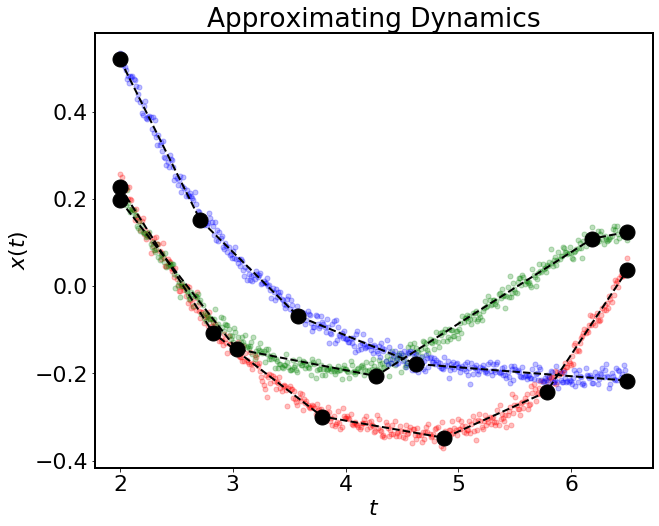

In [32]:
fig = plt.figure(figsize=(10,8))

# chosen_obs = [109, 8]

chosen_obs = [0, 1, 499]  #7]
colors = ['r', 'g', 'b']

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    num_i_knots = int(0.5*(2+len(learn.obs_knots[i])))
    knots = np.copy(learn.obs_knots[i][num_i_knots:])
    knots = np.insert(knots, 0, learn.clean_times[0])
    knots = np.append(knots, learn.clean_times[-1])
    plt.plot(knots, learn.obs_knots[i][:num_i_knots], 'k', linestyle='dashed', markersize=15, marker='o', linewidth=2)
    
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.title('Approximating Dynamics') 

Text(0.5, 1.0, 'Generating Clean Data')

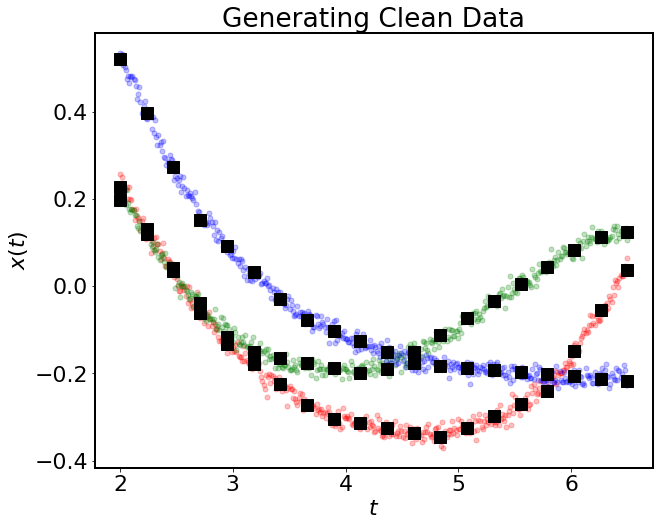

In [33]:
fig = plt.figure(figsize=(10,8))

for i, c in zip(chosen_obs,colors):
    plt.plot(learn.times[time_start_idx:time_end_idx+1], learn.observed_time_series[i,time_start_idx:time_end_idx+1],color=c, linestyle='none', marker='.', markersize=10, alpha=0.25)
    
for i in chosen_obs:
    plt.plot(learn.clean_times, learn.clean_obs[i,:],'k', linestyle='none', marker='s', 
            markersize=12)
    
plt.xlabel('$t$')
plt.ylabel('$x(t)$')
plt.title('Generating Clean Data') 

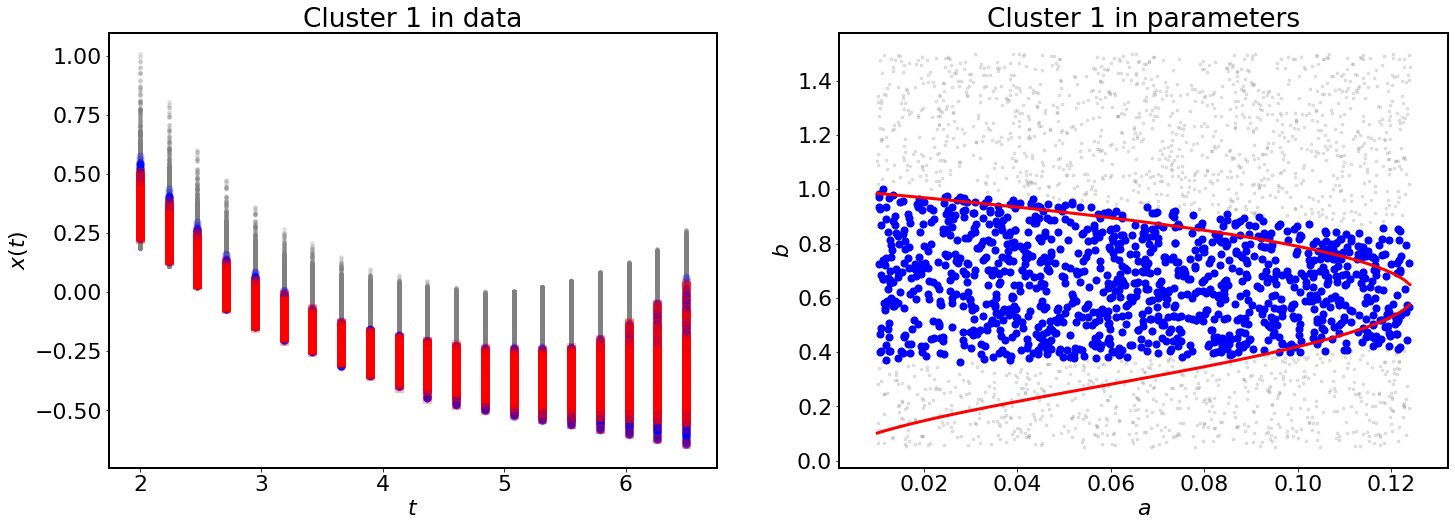

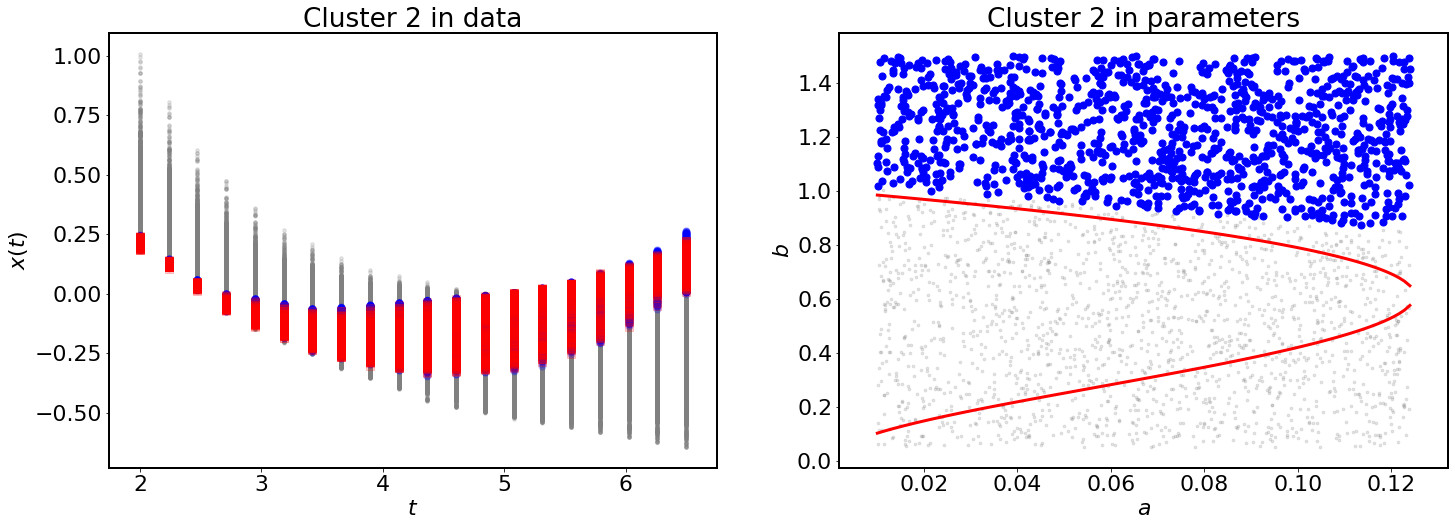

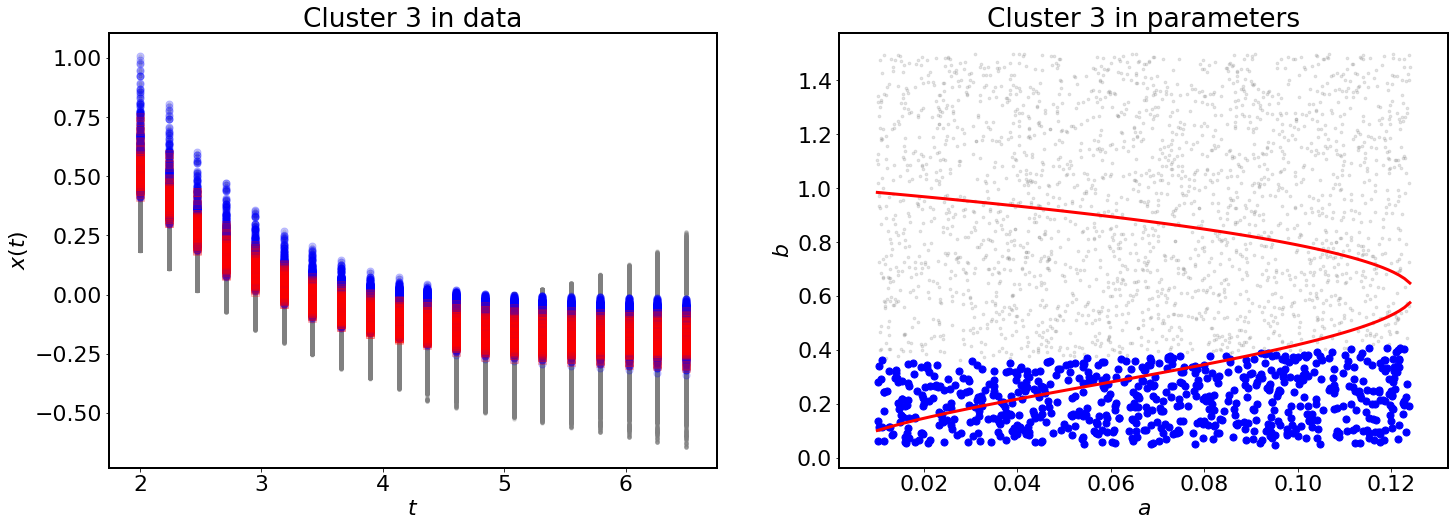

In [37]:
# # Plot clusters of predicted time series
num_clean_obs = learn.clean_times.shape[0]
for j in range(learn.num_clusters):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
    ax1.scatter(np.tile(learn.clean_times,num_samples).reshape(num_samples, num_clean_obs), 
                learn.clean_predictions, 50, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn.predict_labels == j)[0]
    ax1.scatter(np.tile(learn.clean_times,len(idx)).reshape(len(idx),num_clean_obs), 
                learn.clean_predictions[idx,:], 50, c='b', marker='o', alpha=0.2)
    idx2 = np.where(learn.obs_labels == j)[0]    
    ax1.scatter(np.tile(learn.clean_times,len(idx2)).reshape(len(idx2),num_clean_obs), 
                learn.clean_obs[idx2, :], 50, c='r', marker='s', alpha=0.2)
    ax1.set(title='Cluster ' + str(j+1) + ' in data')
    ax1.set_xlabel('$t$')
    ax1.set_ylabel('$x(t)$')
    
    ax2.scatter(params[:,0], params[:,1], 30, c='gray', marker='.', alpha=0.2)
    ax2.scatter(params[idx,0], params[idx,1], 50, c='blue', marker='o')
    ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
    ax2.set_ylabel(param_labels[1])
    ax2.set_xlabel(param_labels[0])
    xs = np.linspace(param_range[0,0], param_range[0,1], 100)
    ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
    ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
    ax2.plot(xs, ys1, 'r-', linewidth=3)
    ax2.plot(xs, ys2, 'r-', linewidth=3)
    fig.tight_layout
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,8), gridspec_kw={'width_ratios': [1, 1]}) 
#     ps = []
#     idx = np.where(learn.predict_labels == j)[0]
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             ps.append(params[i,0]/params[i,1])
#             ax1.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='b', marker='o', alpha=0.2)
#         else:
#             ax1.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='gray', marker='.', alpha=0.2)
#     ax1.set(title='Cluster ' + str(j+1) + ' in data')
#     ax1.set_xlabel('$t$')
#     ax1.set_ylabel('$y(t)$')
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             ax2.scatter(params[i,0], params[i,1], 50, c='blue', marker='o')
#         else:
#             ax2.scatter(params[i,0], params[i,1], 30, c='gray', marker='.', alpha=0.2)
#     ax2.set(title='Cluster ' + str(j+1) + ' in parameters')
#     ax2.set_ylabel(param_labels[1])
#     ax2.set_xlabel(param_labels[0])
#     xs = np.linspace(param_range[0,0], param_range[0,1], 100)
#     ys1 = np.sqrt(0.5*(1.0 - np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ys2 = np.sqrt(0.5*(1.0 + np.sqrt(1.0 - 8.0*xs) -2.0*xs))
#     ax2.plot(xs, ys1, 'r-')
#     ax2.plot(xs, ys2, 'r-')
#     fig.tight_layout

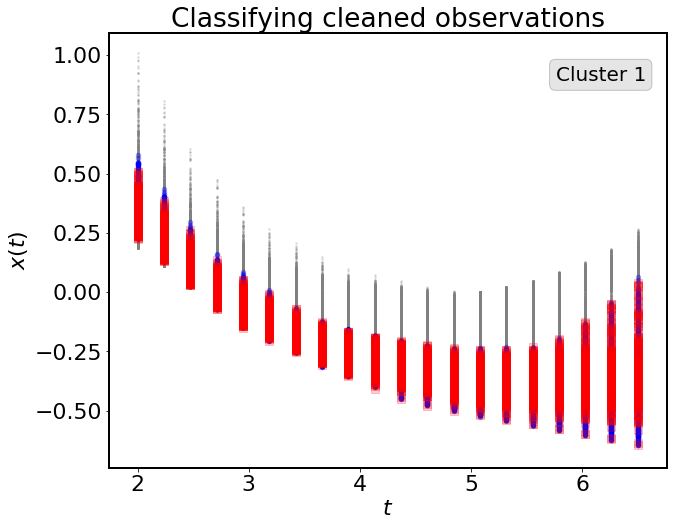

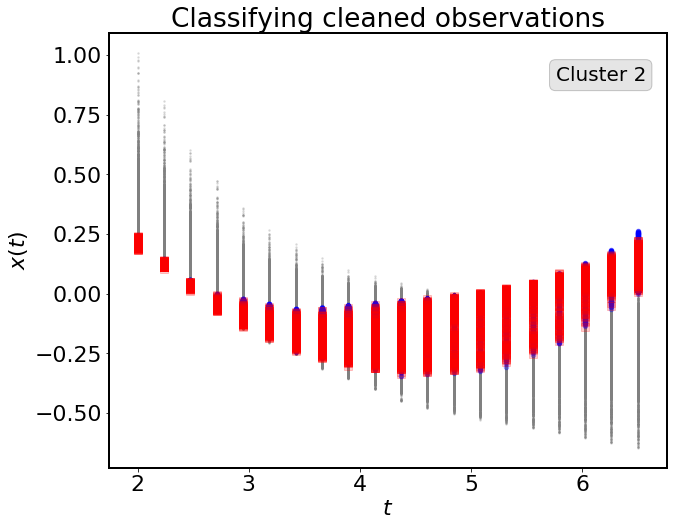

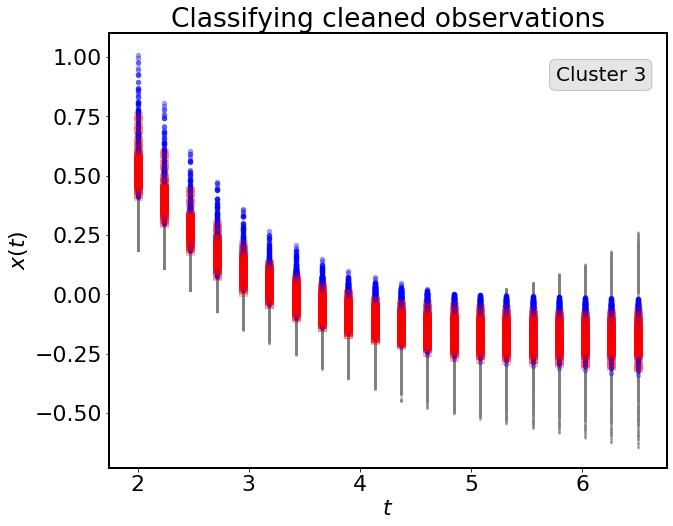

In [11]:
## # Plot oberved and predicted clusters

for j in range(learn.num_clusters):
    fig = plt.figure(figsize=(10,8))
    plt.scatter(np.tile(learn.clean_times,num_samples).reshape(num_samples,num_clean_obs), 
                learn.clean_predictions, 10, c='gray', marker='.', alpha=0.2)
    idx = np.where(learn.predict_labels == j)[0]
    plt.scatter(np.tile(learn.clean_times,len(idx)).reshape(len(idx),num_clean_obs), 
                learn.clean_predictions[idx,:], 20, c='b', marker='o', alpha=0.3)
    idx = np.where(learn.obs_labels == j)[0]    
    plt.scatter(np.tile(learn.clean_times,len(idx)).reshape(len(idx),num_clean_obs), 
                learn.clean_obs[idx, :], 50, c='r', marker='s', alpha=0.2)
    plt.title('Classifying cleaned observations')
    plt.xlabel('$t$')
    plt.ylabel('$x(t)$')
    bottom, top = plt.gca().get_ylim()
    left, right = plt.gca().get_xlim()

    props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
    plt.text(right-1, top-0.2, 
             'Cluster ' + str(j+1), 
             {'color': 'k', 'fontsize': 20},
             bbox=props)
    plt.text
    fig.tight_layout

# for j in range(learn.num_clusters):
#     fig = plt.figure(figsize=(10,8))
#     ps = []
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             ps.append(params[i,0]/params[i,1])
#             plt.scatter(learn.clean_times, learn.clean_predictions[i,:], 50, c='b', marker='.', alpha=0.2)
#         else:
#             plt.scatter(learn.clean_times, learn.clean_predictions[i,:], 20, c='gray', marker='.', alpha=0.2)
#     for i in range(num_obs):        
#         if learn.obs_labels[i] == j:
#             plt.scatter(learn.clean_times, learn.clean_obs[i, :], 50, c='r', marker='o', alpha=0.2)
#     plt.title('Classifying cleaned observations')
#     plt.xlabel('$t$')
#     plt.ylabel('$y(t)$')
#     bottom, top = plt.gca().get_ylim()
#     left, right = plt.gca().get_xlim()
#     props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
#     plt.text(right-1, top-0.2, 
#              'Cluster ' + str(j+1), 
#              {'color': 'k', 'fontsize': 20},
#              bbox=props)
#     plt.text
#     fig.tight_layout

In [12]:
# # Plot clusters of predicted time series
# for j in range(learn.num_clusters):
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,2.5), 
#                                         gridspec_kw={'width_ratios': [3,1,1]}) 
#     ps = []
#     ps2 = []
#     for i in range(num_samples):
#         if learn.predict_labels[i] == j:
#             a = params[i, 0]
#             b = params[i, 1]
#             b1 = sqrt((1.0-sqrt(1.-8.*a)-2.*a)/2.0)
#             b2 = sqrt((1.0+sqrt(1.-8.*a)-2.*a)/2.0)
#             ps.append(b/b1)
#             ps2.append(b/b2)
#             ax1.plot(learn.clean_times, learn.clean_predictions[i, :])
#     ax1.set(title='Cluster ' + str(j))
#     xs = np.linspace(0.0, 5.0, 100)
#     ax2.plot(xs, GKDE(ps)(xs))
#     ax2.axvline(1.0, color='r')
#     ax2.set(xlabel=r'$b/b_1$', title='Param. Distrib.')
#     xs2 = np.linspace(0.0, 2.0, 100)
#     ax3.plot(xs2, GKDE(ps2)(xs2))
#     ax3.axvline(1.0, color='r')
#     ax3.set(xlabel=r'$b/b_2$', title='Param. Distrib.')

In [13]:
# # Plot oberved and predicted clusters
# for j in range(learn.num_clusters):
#     plt.figure()
#     cluster_num = j
#     for i in range(num_samples):
#         if learn.predict_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
#     for i in range(num_obs):
#         if learn.obs_labels[i] == cluster_num:
#             plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [14]:
# Find best KPCA transformation for given number of QoI and transform time series data.
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=2)

2 principal components explain 98.9920% of variance for cluster 0 with {'kernel': 'linear'}
2 principal components explain 53.4257% of variance for cluster 0 with {'kernel': 'rbf'}
2 principal components explain 93.9110% of variance for cluster 0 with {'kernel': 'sigmoid'}
2 principal components explain 78.9174% of variance for cluster 0 with {'kernel': 'poly'}
2 principal components explain 97.7484% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
2 principal components explain 98.9920% of variance.
2 principal components explain 95.5466% of variance for cluster 1 with {'kernel': 'linear'}
2 principal components explain 63.9764% of variance for cluster 1 with {'kernel': 'rbf'}
2 principal components explain 96.2248% of variance for cluster 1 with {'kernel': 'sigmoid'}
2 principal components explain 82.3041% of variance for cluster 1 with {'kernel': 'poly'}
2 principal components explain 92.0973% of variance for cluster 1 with {'ker

In [15]:
%reset -f out

def plot_gap(all_eig_vals, n, cluster):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    #Plotting until maximum number of knots
    eig_vals = all_eig_vals[cluster].lambdas_[0:10]
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals/np.sum(eig_vals)*100, Marker='.', MarkerSize=20, linestyle='')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'k--')
    plt.semilogy(np.arange(np.size(eig_vals))+1,eig_vals[n+1]/np.sum(eig_vals)*100*np.ones(np.size(eig_vals)), 'r--')
    plt.text(n+1, eig_vals[n]/np.sum(eig_vals)*150, 
             r'%2.3f' %(np.sum(eig_vals[0:n+1])/np.sum(eig_vals)*100) + '% of variation explained by first ' + '%1d' %(n+1) + ' PCs.', 
                                                               {'color': 'k', 'fontsize': 20})
    plt.text(n+2, eig_vals[n+1]/np.sum(eig_vals)*150, 
             r'Order of magnitude of gap is %4.2f.' %(np.log10(eig_vals[n])-np.log10(eig_vals[n+1])), 
                                                               {'color': 'r', 'fontsize': 20})
    s = 'Determining QoI for cluster #%1d' %(cluster+1)
    plt.title(s)
    plt.xlabel('Principal Component #')
    plt.ylabel('% of Variation')
    plt.xlim([0.1, np.size(eig_vals)+1])
    plt.ylim([0,500])


wd.interact(plot_gap, all_eig_vals=wd.fixed(learn.kpcas),
            n = wd.IntSlider(value=0, min=0, max=5),
            cluster = wd.IntSlider(value=0, min=0, max=learn.num_clusters-1))

Flushing output cache (3 entries)


interactive(children=(IntSlider(value=0, description='n', max=5), IntSlider(value=0, description='cluster', ma…

<function __main__.plot_gap(all_eig_vals, n, cluster)>

In [16]:
# Generate kernel density estimates on new QoI
learn.generate_kdes()
# Calculate rejection rates for each cluster and print averages.
r_vals = learn.compute_r()

Diagnostic for clusters [sample average of ratios in each cluster]: [0.9857113578275696, 0.948537585619252, 1.0204591303650528]


In [17]:
# Compute marginal probablities for each parameter and initial condition.
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
##for i in range(ics.shape[1]):
#    true_ic_marginals.append(GKDE(ics_obs[:,i]))
#    ic_marginals.append([])
#    for j in range(learn.num_clusters):
#        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [18]:
# uniform distribution
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

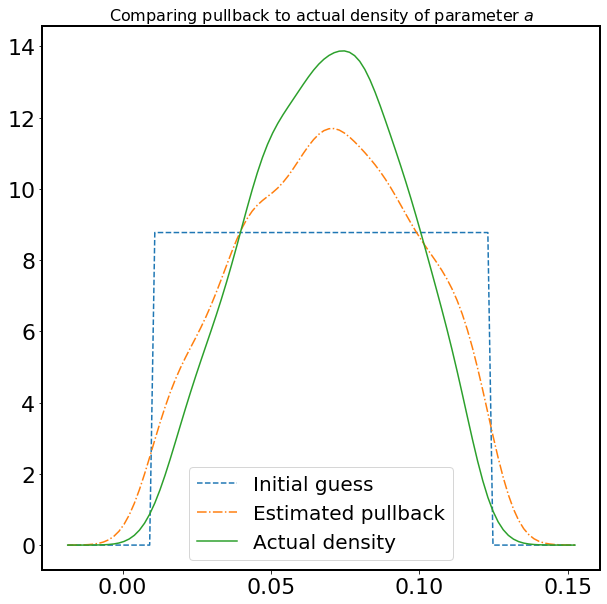

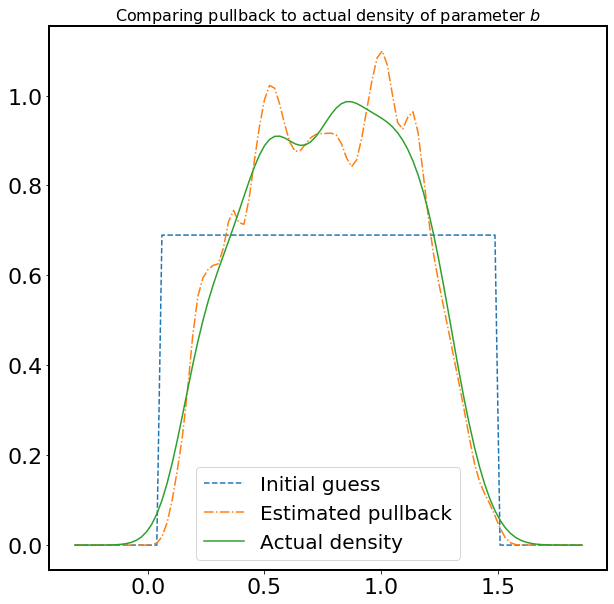

In [19]:
# Plot predicted marginal densities for parameters

for i in range(params.shape[1]):  
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]), '--',
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, '-.', label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)
    if i == 0:
        plt.xticks([0, 0.05, 0.1, 0.15])
    else:
        plt.xticks([0, 0.5, 1., 1.5])

    

In [20]:
# # Plot predicted marginal densities for initial conditions.

# for i in range(ics.shape[1]):
#     fig = plt.figure(figsize=(10,10))
#     fig.clear()
#     x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
#     x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
#     delt = 0.25*(x_max - x_min)
#     x = np.linspace(x_min-delt, x_max+delt, 100)
#     plt.plot(x, unif_dist(x, ic_range[i, :]),
#          label = 'Initial guess')
#     mar = np.zeros(x.shape)
#     for j in range(learn.num_clusters):
#         mar += ic_marginals[i][j](x) * cluster_weights[j]
#     plt.plot(x, mar, label = 'Estimated pullback')
#     plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
#     plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
#     plt.legend(fontsize=20)

### Compute TV metric between densities

In [21]:
import scipy.integrate.quadrature as quad

In [22]:
def param_init_error(x):
    return np.abs(unif_dist(x,param_range[param_num, :])-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_init_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.4083628635477685, 5.872983488419692e-09)
(0.36166797673298867, 2.9112803834330236e-09)


In [23]:
def param_update_KDE_error(x):
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[param_num][j](x) * cluster_weights[j]
    return np.abs(mar-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(param_update_KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.17105561445809545, 5.434507260870802e-09)
(0.07813568178461144, 7.719950179813084e-07)


/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/integrate/quadrature.py:233: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.719950e-07
  AccuracyWarning)


In [24]:
from scipy.stats import beta 

In [25]:
def KDE_error(x):
    true_beta = beta(a=true_a, b=true_b,loc=param_range[i,0],scale=param_range[i,1]-param_range[i,0])
    return np.abs(true_beta.pdf(x)-true_param_marginals[param_num](x))

for i in range(params.shape[1]):
    param_num=i
    TV_metric = quad(KDE_error,param_range[i,0],param_range[i,1],maxiter=1000)
    print(TV_metric)

(0.07520973221639927, 8.898024581038833e-09)
(0.060452977119108485, 8.352453881310673e-09)
